In [58]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
from numpy import mean, std
from mlxtend.plotting import plot_confusion_matrix
from mlxtend.classifier import StackingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_classification
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import recall_score
from sklearn.metrics import make_scorer
from sklearn.metrics import confusion_matrix
import pre as pr

In [59]:
from pre import pipeline_completo


In [60]:
resultados = pipeline_completo('cumulative.csv')
X_train = resultados['X_train']
X_test = resultados['X_test']
y_train = resultados['y_train']
y_test = resultados['y_test']
scaler = resultados['scaler']
feature_names = resultados['feature_names']


               PIPELINE DE DETECCIÓN DE EXOPLANETAS
Cargando datos...
✓ Datos cargados: 9564 filas, 49 columnas

EXPLORACIÓN INICIAL DE DATOS

1. Información del DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9564 entries, 0 to 9563
Data columns (total 49 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   kepid              9564 non-null   int64  
 1   kepoi_name         9564 non-null   object 
 2   kepler_name        2747 non-null   object 
 3   koi_disposition    9564 non-null   object 
 4   koi_pdisposition   9564 non-null   object 
 5   koi_score          8054 non-null   float64
 6   koi_fpflag_nt      9564 non-null   int64  
 7   koi_fpflag_ss      9564 non-null   int64  
 8   koi_fpflag_co      9564 non-null   int64  
 9   koi_fpflag_ec      9564 non-null   int64  
 10  koi_period         9564 non-null   float64
 11  koi_period_err1    9110 non-null   float64
 12  koi_period_err2    9110 non-null   float64


✓ Estado final:
   - Filas: 9564, Columnas: 10
   - Valores faltantes restantes: 0

DETECCIÓN DE OUTLIERS

Columna: koi_period
  - Outliers detectados: 1567
  - Ejemplos (máx 10):
24     386.603053
29     670.645531
96     143.206305
166    235.998640
184    119.020704
185    190.320047
214    226.890478
249    105.145959
265     99.641596
312    102.964195

Columna: koi_impact
  - Outliers detectados: 119
  - Ejemplos (máx 10):
14      2.483
203     7.361
267     9.303
332     2.641
636     4.246
719    12.773
766    13.239
845     5.011
925     3.346
945     7.444

Columna: koi_duration
  - Outliers detectados: 869
  - Ejemplos (máx 10):
15     12.2155
29     53.4120
46     14.5610
118    35.5120
185    15.2840
279    16.9422
312    15.7350
318    23.1440
324    38.1939
343    13.5660

Columna: koi_depth
  - Outliers detectados: 1896
  - Ejemplos (máx 10):
2     10829.0
3      8079.2
9      4914.3
10    14231.0
11     6674.7
12     9145.7
14    17984.0
15     8918.7
16    74284.0
17

In [99]:
def RandomForest_trainer(n= 100, md= 20, split= 5, leaf= 2, state= 42, njobs= -1):
    global rf_model

    rf_model = RandomForestClassifier(
    n_estimators=n,
    max_depth=md,
    min_samples_split= split,
    min_samples_leaf= leaf,
    random_state= state,
    n_jobs=njobs
)
    rf_model.fit(X_train,y_train)
    y_pred = rf_model.predict(X_test)
    y_pred_proba = rf_model.predict_proba(X_test)[:,1]
    print("\n" + "="*60)
    print("RESULTADOS DEL MODELO")
    print("="*60)
    print(f"\n Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    print("\n Classification Report:")
    print(classification_report(y_test, y_pred))
    print("\nConfusion Matrix:")
    return {
        'Accuracy': accuracy_score(y_test, y_pred),
        'confusion_matrix': confusion_matrix(y_test, y_pred),
        'predictions': y_pred
    }


In [100]:
RandomForest_trainer()


RESULTADOS DEL MODELO

 Accuracy: 0.8996

 Classification Report:
(471, 78, 114, 1250)

Confusion Matrix:


{'Accuracy': 0.8996340825927862,
 'confusion_matrix': array([[1250,  114],
        [  78,  471]]),
 'predictions': array([1, 1, 0, ..., 0, 1, 1], shape=(1913,))}

In [102]:
def Evaluation_model (N= 10):
    ''' Implementación de validación cruzada
    Evalua el modelo varias veces'''
    Specificity = make_scorer(recall_score, pos_label=0)


    cross_value_accuracy = RepeatedStratifiedKFold ( n_splits = N, n_repeats=5, random_state=1 ) # Divide los datos en 10 partes, nueve para entrenar 1 para validar. Repite 5 veces con divisiones aleatorias
    n_scores_accuracy = cross_val_score (rf_model, X_test, y_test, scoring = 'accuracy', cv=cross_value_accuracy, 
                                n_jobs =-1, error_score='raise') #
    cross_value_sensitivity = RepeatedStratifiedKFold(n_splits = N, n_repeats=5, random_state=1)
    n_scores_sensititivity = cross_val_score(rf_model, X_test, y_test, scoring='recall', cv=cross_value_sensitivity, 
                                      n_jobs=-1, error_score='raise')
    
    cross_value_specificity = RepeatedStratifiedKFold(n_splits =N, n_repeats=5, random_state=1)
    n_scores_specificity = cross_val_score(rf_model, X_test, y_test, cv=cross_value_specificity, scoring = Specificity,
                                n_jobs=-1, error_score='raise')
    cross_value_precision = RepeatedStratifiedKFold(n_splits =N, n_repeats=5, random_state=1)
    n_scores_precision = cross_val_score(rf_model, X_test, y_test, cv=cross_value_precision, scoring = 'precision' ,
                                n_jobs=-1, error_score='raise')
    cross_value_f1 = RepeatedStratifiedKFold(n_splits =N,  n_repeats=5, random_state=1)
    n_scores_f1 = cross_val_score(rf_model, X_test, y_test, cv=cross_value_f1, scoring = 'f1',
                                n_jobs=-1, error_score='raise')
    #print(n_scores)
    # report performance
    print('Accuracy: %.4f (%.4f)' % (mean(n_scores_accuracy), std(n_scores_accuracy))) #Promedio de las 50 accuracies
    print('sensitivity: %.4f (%.4f)' % (mean(n_scores_sensititivity), std(n_scores_sensititivity)))
    print('specificity: %.4f (%.4f)' % (mean(n_scores_specificity), std(n_scores_specificity)))
    print('precision: %.4f (%.4f)' % (mean(n_scores_precision), std(n_scores_precision)))
    print('f1: %.4f (%.4f)' % (mean(n_scores_f1), std(n_scores_f1)))

        #print(n_scores)
        # report performance
    

In [103]:
Evaluation_model()

Accuracy: 0.8856 (0.0193)
sensitivity: 0.7581 (0.0500)
specificity: 0.9369 (0.0220)
precision: 0.8314 (0.0475)
f1: 0.7916 (0.0354)


In [101]:
def classification_report(y_true, y_pred, positive_label=1):
    tp = fn = fp = tn = 0
    
    for i, j in zip(y_true, y_pred):
        if i == positive_label:
            if j == positive_label:
                tp += 1
            else:
                fn += 1
        else:
            if j == positive_label:
                fp += 1
            else:
                tn += 1
    
    accuracy = (tp + tn) / (tp + fn + fp + tn)
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'specificity': specificity,
        'f1_score': f1,
        'tp': tp, 'fn': fn, 'fp': fp, 'tn': tn
    }

In [64]:
start_time = time.time()

In [79]:
#Print Time
print("--- %s seconds ---" % (time.time() - start_time))

--- 2319.0336594581604 seconds ---


In [82]:
def Predictions (X_test):
    y_pred_accuracy = rf_model.predict(X_test)
    print(" Accuracy: {:.3f}%".format(accuracy(*classification_report(y_test, y_pred_accuracy)) * 100))

    y_pred_sensitivity = rf_model.predict(X_test)
    print(" Sensitivity: {:.3f}%".format(sensitivity(*classification_report(y_test, y_pred_sensitivity)) * 100))

    y_pred_precision = rf_model.predict(X_test)
    print(" Precision: {:.3f}%".format(precision(*classification_report(y_test, y_pred_precision)) * 100))

    y_pred_f1 = rf_model.predict(X_test)
    print(" F1 Score: {:.3f}%".format(f1_score(*classification_report(y_test, y_pred_f1)) * 100))
    return {
        'Accuracy': y_pred_accuracy,
        'Sensitivity': y_pred_sensitivity,
        'Precision': y_pred_precision,
        'F1': y_pred_f1
    }

In [83]:
Predictions(X_test)

 Accuracy: 89.963%
 Sensitivity: 85.792%
 Precision: 80.513%
 F1 Score: 83.069%


{'Accuracy': array([1, 1, 0, ..., 0, 1, 1], shape=(1913,)),
 'Sensitivity': array([1, 1, 0, ..., 0, 1, 1], shape=(1913,)),
 'Precision': array([1, 1, 0, ..., 0, 1, 1], shape=(1913,)),
 'F1': array([1, 1, 0, ..., 0, 1, 1], shape=(1913,))}

In [106]:
def Plotting_matrix ():
    y_pred = rf_model.predict(X_test)
    cf_matrix = confusion_matrix(y_test, y_pred)
    group_names = ['True Neg','False Pos','False Neg','True Pos']

    group_counts = ["{0:0.0f}".format(value) for value in
    cf_matrix.flatten()]

    group_percentages = ["{0:.2%}".format(value) for value in
        cf_matrix.flatten()/np.sum(cf_matrix)]

    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
    zip(group_names,group_counts,group_percentages)]

    labels = np.asarray(labels).reshape(2,2)

    ax = sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

    #ax.set_title('Confusion Matrix with labels\n\n');
    ax.set_xlabel('Valores preditos pelo modelo')
    ax.set_ylabel('Valores reais ');

    ## Ticket labels - List must be in alphabetical order
    ax.xaxis.set_ticklabels(['False','True'])
    ax.yaxis.set_ticklabels(['False','True'])

    ## Display the visualization of the Confusion Matrix.
    plt.savefig('my_plot.JPEG')
    plt.show()

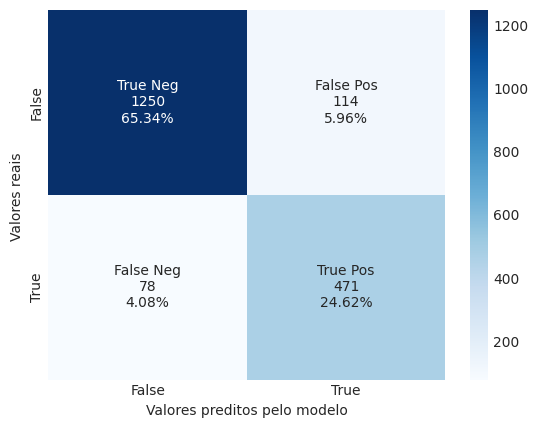

In [107]:
Plotting_matrix()

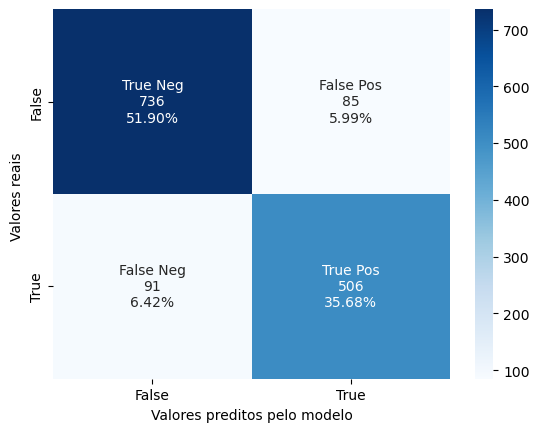

In [ ]:
y_pred = classifier.predict(X_test)
cf_matrix = confusion_matrix(y_test, y_pred)
group_names = ['True Neg','False Pos','False Neg','True Pos']

group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]

group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]

labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]

labels = np.asarray(labels).reshape(2,2)

ax = sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

#ax.set_title('Confusion Matrix with labels\n\n');
ax.set_xlabel('Valores preditos pelo modelo')
ax.set_ylabel('Valores reais ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.savefig('my_plot.JPEG')
plt.show()